## import package

In [2]:
# ! pip install scikit-learn

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [4]:
torch.manual_seed(42)

## Datasets

In [169]:
# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")
else:
    device = torch.device("mps")
    print(device)

if not torch.cuda.is_available():
    None
else:
    device = torch.device("cuda")
    print(device)


mps


In [170]:
# read the CSV file
data = pd.read_csv('ann_datasets.csv')
print(f"data numbers: {len(data)}")
print(f"data sets: {int(len(data)/1279)}")


# deal the input
input_features = 'sbi'
output_feature = 'sbi_30min'
num_stations = 1279 # station numbers
group_size = num_stations  # each input element size

num_groups = len(data) // group_size  # set numbers
input_data = np.zeros((num_groups, group_size))

for i in range(num_groups):
    start_idx = i * group_size
    end_idx = start_idx + group_size
    group_data = data.iloc[start_idx:end_idx]

    for j, row in group_data.iterrows():
        station_index = j % group_size
        input_data[i, station_index] = row[input_features]

# deal the output
output_data = np.zeros((num_groups, group_size))

for i in range(num_groups):
    start_idx = i * group_size
    end_idx = start_idx + group_size
    group_data = data.iloc[start_idx:end_idx]

    for j, row in group_data.iterrows():
        station_index = j % group_size
        output_data[i, station_index] = row[output_feature]

# check the dimension
print('Input shape:', input_data.shape)  # (set, element size)
print('Output shape:', output_data.shape)  # (set, element size)

data numbers: 4801366
data sets: 3754
Input shape: (3754, 1279)
Output shape: (3754, 1279)


In [171]:
# split the datasets to the training and validation.
train_input, val_input, train_output, val_output = train_test_split(input_data, output_data, test_size=0.2, random_state=42)

print('Training input shape:', train_input.shape)
print('Validation input shape:', val_input.shape)
print('Training output shape:', train_output.shape)
print('Validation output shape:', val_output.shape)

Training input shape: (3003, 1279)
Validation input shape: (751, 1279)
Training output shape: (3003, 1279)
Validation output shape: (751, 1279)


## Model

In [191]:
class MyModel(nn.Module):
    def __init__(self, model_idx, input_dim, output_dim):
        super(MyModel, self).__init__()
        
        self.models = {
            1: nn.Sequential(
                nn.Linear(input_dim, output_dim)
            ),
            2: nn.Sequential(
                nn.Linear(input_dim, 512),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(512, 512),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(512, output_dim)
            ),
            3: nn.Sequential(
                nn.Linear(input_dim, 512),
                nn.LeakyReLU(),
                nn.Linear(512, 512),
                nn.LeakyReLU(),
                nn.Linear(512, output_dim)
            ),
            4: nn.Sequential(
                nn.Linear(input_dim, 512),
                nn.LeakyReLU(),
                nn.Linear(512, 256),
                nn.LeakyReLU(),
                nn.Linear(256, 128),
                nn.LeakyReLU(),
                nn.Linear(128, 64),
                nn.LeakyReLU(),
                nn.Linear(64, output_dim)
            )
        }
        
        self.model_idx = model_idx
        self.model = self.models[model_idx]

    def forward(self, x):
        out = self.model(x)
        return out

## hyperparameters

In [372]:
# define the hyperparameters
model_idx = 4
input_dim = train_input.shape[1]  # 1279
output_dim = train_output.shape[1]  # 1279
num_epochs = 200
learning_rate = 0.001
save_model_or_not = 0

## loss function and optimizer

In [373]:
# push model to GPU
model = MyModel(model_idx, input_dim, output_dim).to(device)

# define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [374]:
model

MyModel(
  (model): Sequential(
    (0): Linear(in_features=1279, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=64, out_features=1279, bias=True)
  )
)

In [375]:
# convert the training data to tensor(vector)
train_input_tensor = torch.Tensor(train_input).to(device)
train_output_tensor = torch.Tensor(train_output).to(device)

# convert the validatioin data to tensor(vector)
val_input_tensor = torch.Tensor(val_input).to(device)
val_output_tensor = torch.Tensor(val_output).to(device)

## Training

In [376]:
# build a list to save the loss data
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # forward propagration
    output = model(train_input_tensor)

    # calculate the training loss
    train_loss = criterion(output, train_output_tensor)

    # back propagation and update the weight
    train_loss.backward()
    optimizer.step()

    # # update learning rate
    # scheduler.step()

    # evaluate the model and calculate the validation loss
    model.eval()
    with torch.no_grad():
        val_output_pred = model(val_input_tensor)
        val_loss = criterion(val_output_pred, val_output_tensor)

    # save the value of loss
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())

    # print the info.
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss.item()}, Val Loss: {val_loss.item()}")



Epoch 1/200, Train Loss: 58947.37109375, Val Loss: 58955.359375
Epoch 2/200, Train Loss: 58935.765625, Val Loss: 58869.96875
Epoch 3/200, Train Loss: 58848.80078125, Val Loss: 58839.84375
Epoch 4/200, Train Loss: 58818.34765625, Val Loss: 58793.2578125
Epoch 5/200, Train Loss: 58771.80859375, Val Loss: 58757.58984375
Epoch 6/200, Train Loss: 58734.9609375, Val Loss: 58720.26953125
Epoch 7/200, Train Loss: 58696.28515625, Val Loss: 58672.9921875
Epoch 8/200, Train Loss: 58648.64453125, Val Loss: 58620.9765625
Epoch 9/200, Train Loss: 58595.09765625, Val Loss: 58567.09765625
Epoch 10/200, Train Loss: 58540.65234375, Val Loss: 58506.89453125
Epoch 11/200, Train Loss: 58480.45703125, Val Loss: 58440.59375
Epoch 12/200, Train Loss: 58413.32421875, Val Loss: 58376.7578125
Epoch 13/200, Train Loss: 58347.9921875, Val Loss: 58301.1796875
Epoch 14/200, Train Loss: 58271.4921875, Val Loss: 58226.12109375
Epoch 15/200, Train Loss: 58195.2421875, Val Loss: 58145.765625
Epoch 16/200, Train Loss: 58

## save the model

In [377]:
# save the model
if save_model_or_not == True:
  torch.save(model.state_dict(), 'model.pt')
  print("save done")

## plot the loss trend line

In [378]:
from matplotlib import pyplot as plt 

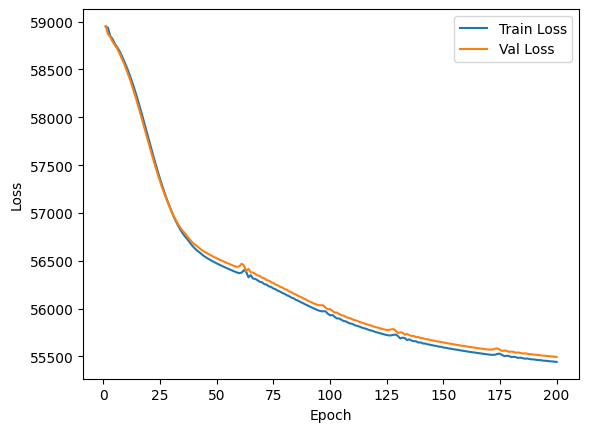

In [379]:
# plot loss-epochs diagrame
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## evaluate the test data

In [380]:
# cannot use f1 score to evaluate model, because it is for classification used.
def compute_f1_score(predictions, targets):
    binary_predictions = torch.round(torch.sigmoid(predictions)).cpu().numpy()
    targets = targets.cpu().numpy()

    true_positives = np.sum(np.logical_and(binary_predictions == 1, targets == 1))
    false_positives = np.sum(np.logical_and(binary_predictions == 1, targets == 0))
    false_negatives = np.sum(np.logical_and(binary_predictions == 0, targets == 1))

    precision = true_positives / (true_positives + false_positives + 1e-8)
    recall = true_positives / (true_positives + false_negatives + 1e-8)

    f1_score = 2 * (precision * recall) / (precision + recall + 1e-8)

    return precision, recall, f1_score

In [381]:
# read test datasets
data = pd.read_csv('ann_datasets_test.csv')
print(f"data numbers: {len(data)}")
print(f"data sets: {int(len(data)/1279)}")

input_features = 'sbi'
output_feature = 'sbi_30min'
num_stations = 1279
group_size = num_stations

num_groups = len(data) // group_size
input_test_data = np.zeros((num_groups, group_size))

data numbers: 38370
data sets: 30


In [382]:
for i in range(num_groups):
    start_idx = i * group_size
    end_idx = start_idx + group_size
    group_data = data.iloc[start_idx:end_idx]

    for j, row in group_data.iterrows():
        station_index = j % group_size
        input_data[i, station_index] = row[input_features]

output_test_data = np.zeros((num_groups, group_size))

for i in range(num_groups):
    start_idx = i * group_size
    end_idx = start_idx + group_size
    group_data = data.iloc[start_idx:end_idx]

    for j, row in group_data.iterrows():
        station_index = j % group_size
        output_test_data[i, station_index] = row[output_feature]

In [383]:
# turn into torch vector
input_data_tensor = torch.Tensor(input_test_data).to(device)
output_data_tensor = torch.Tensor(output_test_data).to(device)

In [384]:
model = MyModel(model_idx, input_dim, output_dim).to(device)

# predict
with torch.no_grad():
    test_output_pred = model(input_data_tensor)

# calculate precision, recall, f1_score
precision, recall, f1_score = compute_f1_score(test_output_pred, output_data_tensor)
# calculate MAE
mae = torch.abs(test_output_pred - output_data_tensor).mean()
print(f"MAE:{mae.item():.2f}")
# calculate MSE
mse = ((test_output_pred - output_data_tensor) ** 2).mean()
print(f"MSE:{mse.item():.2f}")

MAE:5.52
MSE:72.76


## Ensemble

In [385]:
# hyperparameters
ensenble_or_not = 0
model_num = 4
input_dim = train_input.shape[1]  # 1279
output_dim = train_output.shape[1]  # 1279
num_epochs = 200
learning_rate = 0.001
save_model_or_not = 1

In [386]:
# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

In [387]:
# save the trained model
trained_models = []
if ensenble_or_not == True:
    for idx in range(model_num):

        model = MyModel(model_idx, input_dim, output_dim).to(device)

        trained_models.append(model)

        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

        train_input_tensor = torch.Tensor(train_input).to(device)
        train_output_tensor = torch.Tensor(train_output).to(device)

        for epoch in range(num_epochs):
            outputs = model(train_input_tensor)
            loss = criterion(outputs, train_output_tensor)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}")

        if save_model_or_not:
            torch.save(model.state_dict(), f"Ensemble_model{idx + 1}.pt")

In [388]:
if ensenble_or_not == True:
    # turn into torch vector
    input_data_tensor = torch.Tensor(input_test_data)
    output_data_tensor = torch.Tensor(output_test_data)

In [389]:
# Create a list to store the loaded models
loaded_models = []
if ensenble_or_not == True:

    # Load model weights
    for idx in range(model_num):
        model_ensamble = MyModel(model_idx, input_dim, output_dim)
        model_ensamble.load_state_dict(torch.load(f"Ensemble_model{idx + 1}.pt", map_location=torch.device("cpu")))
        model_ensamble.eval()
        loaded_models.append(model_ensamble)

    def ensemble_vote(models, input_data):
        # Perform predictions with each model
        predictions = [model(input_data) for model in models]
        
        # Compute the mode of predictions
        final_predictions = torch.mode(torch.stack(predictions), dim=0).values
        
        return final_predictions

    # Perform ensemble voting using loaded models
    with torch.no_grad():
        ensemble_predictions_vote = ensemble_vote(loaded_models, input_data_tensor)

    # calculate MAE
    mae = torch.abs(ensemble_predictions_vote - output_data_tensor).mean()
    print(f"MAE:{mae.item():.2f}")
    # calculate MSE
    mse = ((ensemble_predictions_vote - output_data_tensor) ** 2).mean()
    print(f"MSE:{mse.item():.2f}")